# XGBoost implementation for Time series forecasting in stock prices

pip install xgboost

## Libraries

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report

import xgboost as xgb

## Data preprocessing

The initial hypothesis is that we need to take a look at the fields related to the stock prices and trading sales. In order to analyze if the prices seem to be relevant in the trading volume

In [12]:
df_msft = pd.read_csv('../database/ticker_MSFT.csv')
df_goog = pd.read_csv('../database/ticker_GOOG.csv')
df_v = pd.read_csv('../database/ticker_V.csv')


In [13]:
df_msft

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol
0,2021-12-06,323.950012,327.450012,319.230011,326.190002,320.321655,30032600,MSFT
1,2021-12-07,331.640015,335.799988,330.100006,334.920013,328.894592,31021900,MSFT
2,2021-12-08,335.309998,335.500000,330.799988,334.970001,328.943665,24761000,MSFT
3,2021-12-09,334.410004,336.489990,332.119995,333.100006,327.107300,22214200,MSFT
4,2021-12-10,334.980011,343.000000,334.790009,342.540009,336.377502,38095700,MSFT
...,...,...,...,...,...,...,...,...
498,2023-11-29,383.760010,384.299988,377.440002,378.850006,378.850006,28963400,MSFT
499,2023-11-30,378.489990,380.089996,375.470001,378.910004,378.910004,30554400,MSFT
500,2023-12-01,376.760010,378.160004,371.309998,374.510010,374.510010,33020400,MSFT
501,2023-12-04,369.100006,369.519989,362.899994,369.140015,369.140015,32037800,MSFT


Set the 'date' field as an index and making sure it is a datetime and not a string for plotting purposes

In [14]:
def setIndex(df):
    
    df = df.set_index('Date')
    df.index = pd.to_datetime(df.index)
    
    return df

In [15]:
df_msft = setIndex(df_msft)

In [25]:
df_msft

,Open,High,Low,Close,Adj Close,Volume,Symbol
Date,,,,,,,
2021-12-06,323.950012,327.450012,319.230011,326.190002,320.321655,30032600,MSFT
2021-12-07,331.640015,335.799988,330.100006,334.920013,328.894592,31021900,MSFT
2021-12-08,335.309998,335.500000,330.799988,334.970001,328.943665,24761000,MSFT
2021-12-09,334.410004,336.489990,332.119995,333.100006,327.107300,22214200,MSFT
2021-12-10,334.980011,343.000000,334.790009,342.540009,336.377502,38095700,MSFT
...,...,...,...,...,...,...,...
2023-11-29,383.760010,384.299988,377.440002,378.850006,378.850006,28963400,MSFT
2023-11-30,378.489990,380.089996,375.470001,378.910004,378.910004,30554400,MSFT
2023-12-01,376.760010,378.160004,371.309998,374.510010,374.510010,33020400,MSFT


#### Plot Variables

In [16]:
def plotVariables(df,vars, title):
    df[vars].plot(
        figsize=(15,7), 
        title=title,
        subplots = True
    )

    plt.show()

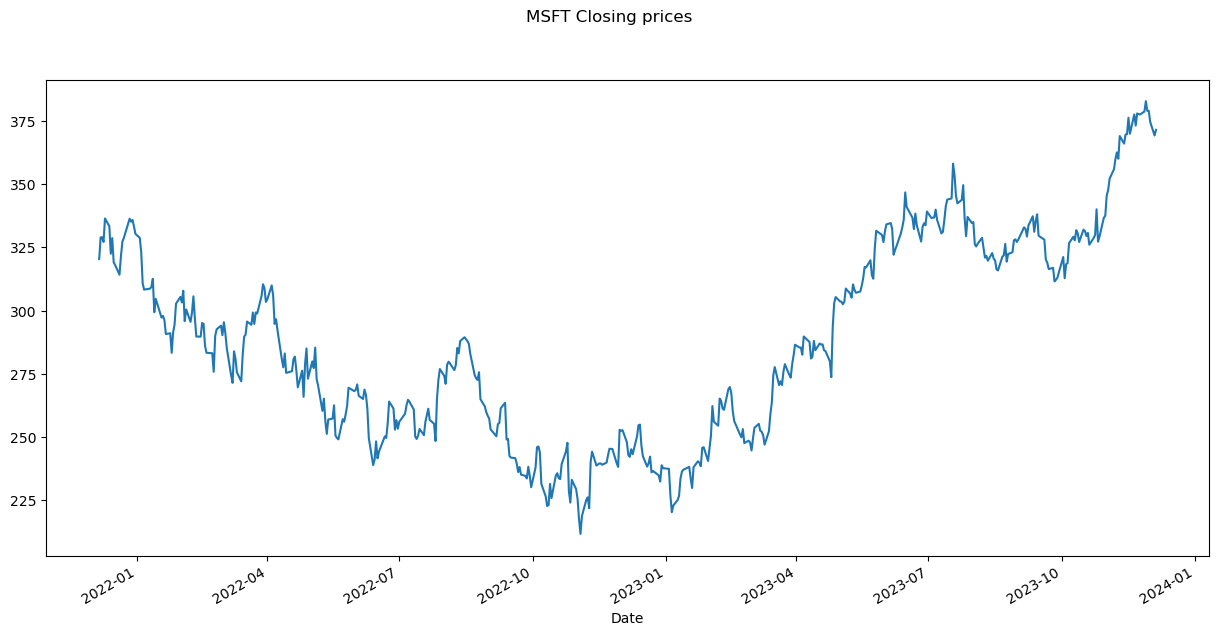

In [17]:
plotVariables(df_msft,'Adj Close','MSFT Closing prices')

## Feature creation

The next step is to create the necessary features for defining the stock's performance and forecast this same metric. Since we have an datetime index we can break this data into its components such as:

- Year
- Month
- Quarter
- Day

In order to get an easier view of the data and how did the stocks performed in different periods of time. 

Also for an accurrate prediction of whether to buy or sell stocks we'll do the calculations of multiple indexes such as the following:

- Relative Strength Index (RSI)
- Stochastic Oscillator
- Williams percentage range
- Moving Average convergence divergence
- Price rate of change
- On balance volume

These are momentum indicators that give buy and sell signals based on their results. We'll have a definition period of 14 days by default for the calculation of these indexes

Also we will calculate the Logarithmic returns of the closing prices of these stocks, this is a metric that returns a decimal that we can turn into a percentage. It indicates the performance of the stock and they are additive over time for further analysis. 


\begin{align*}

R = ln (\frac{P_t}{P_{t-1}}) \\
\end{align*}

In [35]:
period = 14

In [39]:
def addTimeFeatures(df):
    """Adds time features to the dataframe based on a datetime index"""
    df['Quarter'] = df.index.quarter
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['Day'] = df.index.day
    
    return df

def addGainLoss(df):
    """Calculates gain or loss on the closing price of a stock"""
    df['Gain'] = df['Close'].diff().where(lambda x: x > 0, 0)
    df['Loss'] = abs(df['Close'].diff().where(lambda x: x < 0, 0))
    
    return df

def RSI(df):
    """Momentum indication that states if the stock is overbought or oversold"""
    
    #df['RSI'] = 
    avg_gain = df['Gain'].rolling(window=period).mean()
    avg_loss = df['Loss'].rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100.0 - (100.0 / (1.0 + rs))

    df['RSI'] = rsi
    return df

def stochasticOscillator(df):
    return df

def williamsRate(df):
    return df

def movingAverage(df):
    return df

def rateChange(df):
    return df

def onBalanceVolume(df):
    return df

In [40]:
def addFeatures(df):
    
    df = addTimeFeatures(df)
    df = addGainLoss(df)
    df = RSI(df)

    return df

In [43]:
df_msft = addFeatures(df_msft)

,Open,High,Low,Close,Adj Close,Volume,Symbol,quarter,month,year,day,Quarter,Month,Year,Day,Gain,Loss,RSI
Date,,,,,,,,,,,,,,,,,,
2021-12-06,323.950012,327.450012,319.230011,326.190002,320.321655,30032600,MSFT,4,12,2021,6,4,12,2021,6,0.000000,0.000000,NaN
2021-12-07,331.640015,335.799988,330.100006,334.920013,328.894592,31021900,MSFT,4,12,2021,7,4,12,2021,7,8.730011,0.000000,NaN
2021-12-08,335.309998,335.500000,330.799988,334.970001,328.943665,24761000,MSFT,4,12,2021,8,4,12,2021,8,0.049988,0.000000,NaN
2021-12-09,334.410004,336.489990,332.119995,333.100006,327.107300,22214200,MSFT,4,12,2021,9,4,12,2021,9,0.000000,1.869995,NaN
2021-12-10,334.980011,343.000000,334.790009,342.540009,336.377502,38095700,MSFT,4,12,2021,10,4,12,2021,10,9.440002,0.000000,NaN
2021-12-13,340.679993,343.790009,339.079987,339.399994,333.294006,28899400,MSFT,4,12,2021,13,4,12,2021,13,0.000000,3.140015,NaN
2021-12-14,333.220001,334.640015,324.109985,328.339996,322.432953,44438700,MSFT,4,12,2021,14,4,12,2021,14,0.000000,11.059998,NaN
2021-12-15,328.609985,335.190002,324.500000,334.649994,328.629456,35381100,MSFT,4,12,2021,15,4,12,2021,15,6.309998,0.000000,NaN
2021-12-16,335.709991,336.760010,323.019989,324.899994,319.054871,35034800,MSFT,4,12,2021,16,4,12,2021,16,0.000000,9.750000,NaN


#### Display the addition of log returns per year and quarter

In [295]:
added_logreturn_quarter = df.groupby(['year','quarter'])['log_ret'].sum()
added_logreturn_year = df.groupby('year')['log_ret'].sum()

Text(0, 0.5, 'Sum of Log Returns')

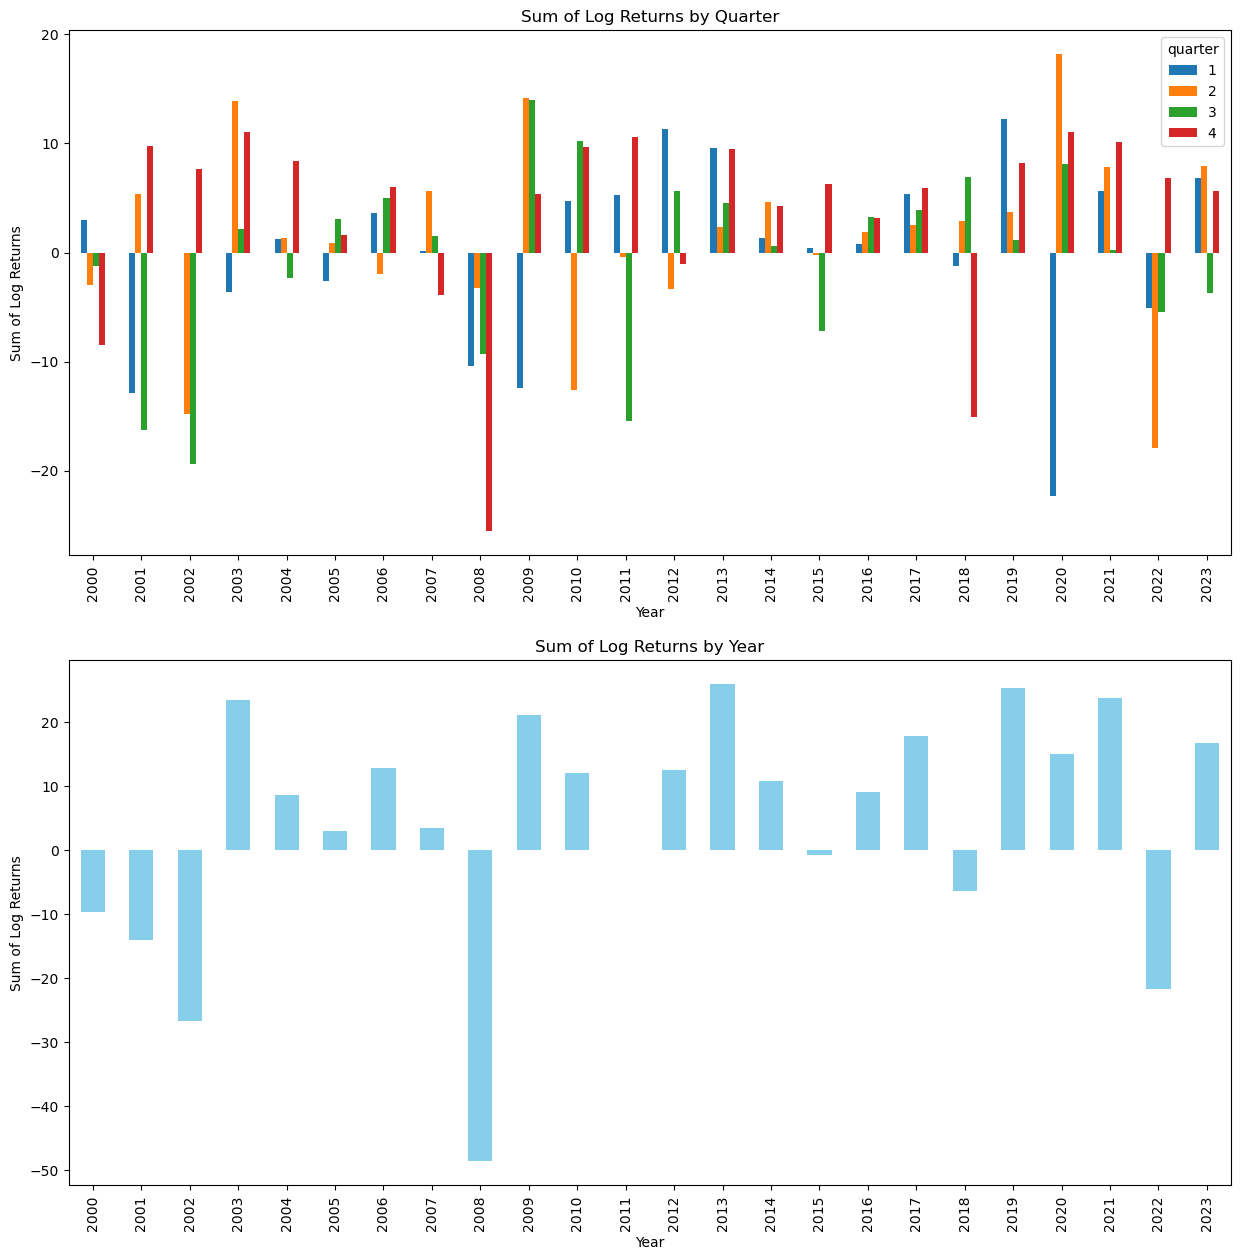

In [296]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15),)

# Plot for added_logreturn_quarter
added_logreturn_quarter.unstack().plot(kind='bar', ax=axes[0])
axes[0].set_title('Sum of Log Returns by Quarter')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Sum of Log Returns')

# Plot for added_logreturn_year
added_logreturn_year.plot(kind='bar', ax=axes[1], color='skyblue')
axes[1].set_title('Sum of Log Returns by Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Sum of Log Returns')

<Axes: xlabel='date'>

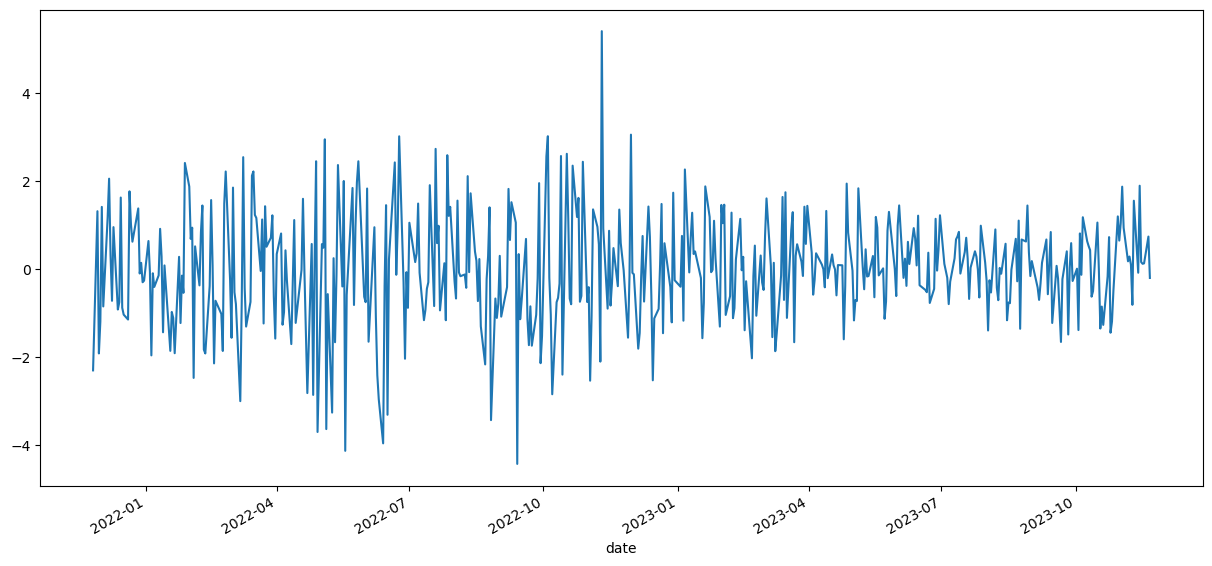

In [297]:
df['log_ret'][-500:].plot(
        style='-',
        figsize=(15,7), 
    )

## Create out model

To create an adeauate model and correclty predict our desired target, first we need to applu our **addFeatures** fucntion to both our tarining and testing dataframes. And later on we must set the features that will be used for the prediction of our target.

In [298]:
train = addFeatures(train)
test = addFeatures(test)

FEATURES = ['close','volume','avg_vol_20d','year','quarter','month']
TARGET = 'log_ret'


C:\Users\guzma\AppData\Local\Temp\ipykernel_21328\3394033471.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_ret'][0] = 0
C:\Users\guzma\AppData\Local\Temp\ipykernel_21328\3394033471.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_ret'][0] = 0


Set get the desired features from our dataframes

In [299]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [300]:
model = xgb.XGBRegressor()

model.fit(
    X_train,
    y_train,
    verbose = 100    
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [301]:
fi = pd.DataFrame(
    data = model.feature_importances_, 
    index=model.feature_names_in_,
    columns=['importance']
    )

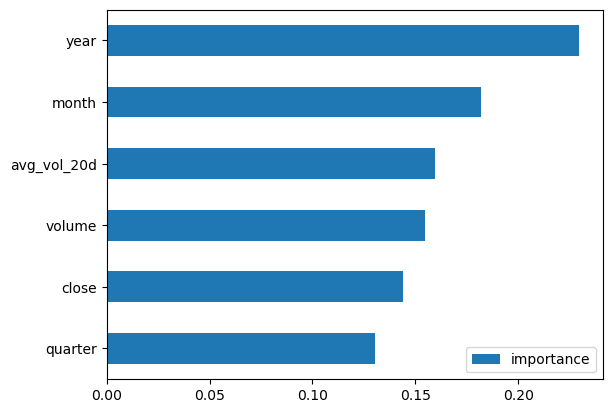

In [302]:
fi.sort_values('importance').plot(kind='barh')
plt.show()

In [303]:
test['forecast'] = model.predict(X_test)


In [304]:
test

,open,high,low,close,volume,change_percent,avg_vol_20d,quarter,month,year,log_ret,forecast
date,,,,,,,,,,,,
2015-01-02,2058.8999,2072.3601,2046.0400,2058.2000,2708700000,-0.03,3.599709e+09,1,1,2015,0.000000,0.317330
2015-01-05,2054.4399,2054.4399,2017.3400,2020.5800,3799120000,-1.83,3.619248e+09,1,1,2015,-1.844722,0.358698
2015-01-06,2022.1500,2030.2500,1992.4399,2002.6100,4460110000,-0.89,3.671272e+09,1,1,2015,-0.893327,-0.458559
2015-01-07,2005.5500,2029.6100,2005.5500,2025.9000,3805480000,1.16,3.671497e+09,1,1,2015,1.156272,0.358698
2015-01-08,2030.6100,2064.0801,2030.6100,2062.1399,3934010000,1.79,3.669690e+09,1,1,2015,1.773018,0.428453
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-15,4505.2998,4521.1699,4495.3101,4502.8799,4347170000,0.16,4.024057e+09,4,11,2023,0.159574,0.639242
2023-11-16,4497.0801,4511.9902,4487.8301,4508.2402,3964520000,0.12,4.023796e+09,4,11,2023,0.118971,0.492882
2023-11-17,4509.5498,4520.1201,4499.6602,4514.0200,3777240000,0.13,4.012457e+09,4,11,2023,0.128123,0.493274


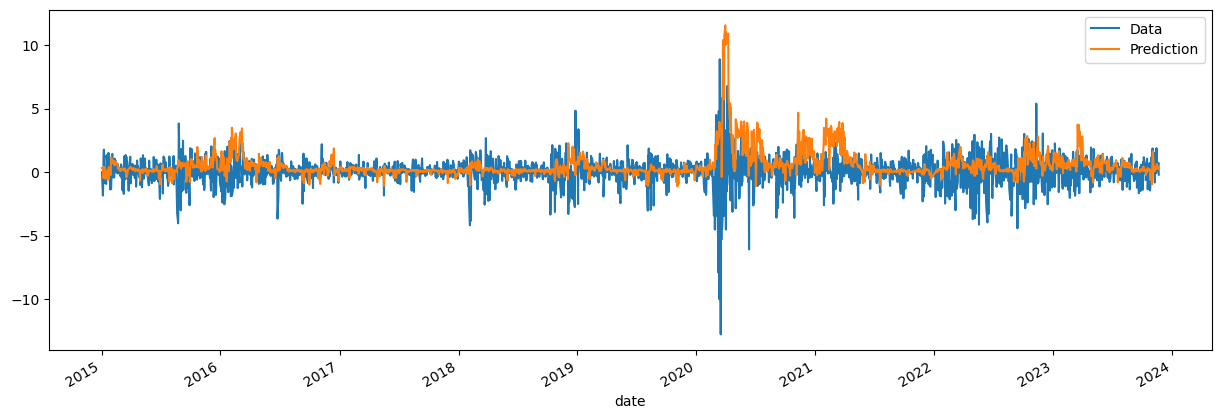

In [305]:
ax = test[['log_ret']].plot(figsize=(15,5))
test['forecast'].plot(ax=ax)
plt.legend(['Data','Prediction'])
plt.show()